In [86]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import re

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import seaborn as sns
from sklearn.datasets import make_blobs, make_moons
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler


import warnings
warnings.filterwarnings(action='ignore')
%matplotlib inline

In [87]:
df = pd.read_csv("KR.csv", encoding="utf-8", low_memory=True)
print(df.shape)
display(df.head())

(93921, 20)


,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,112adU33vo4C1eRZct2hWy,Nuits De Chine,4,180800,0,['Louis Lynel'],['28pbIiOohRRZjqpAM9iqYM'],1922,0.420,0.2880,7,-14.005,1,0.0701,0.994,0.000216,0.196,0.400,139.575,3
1,35iwgR4jXetI318WEWsa1Q,Carve,6,126903,0,['Uli'],['45tIt06XoI0Iio4LBEVpls'],1922-02-22,0.645,0.4450,0,-13.338,1,0.4510,0.674,0.744000,0.151,0.127,104.851,3
2,021ht4sdgPcrDgSk7JTbKY,Capítulo 2.16 - Banquero Anarquista,0,98200,0,['Fernando Pessoa'],['14jtPCOoNZwquk5wd9DxrY'],1922-06-01,0.695,0.2630,0,-22.136,1,0.9570,0.797,0.000000,0.148,0.655,102.009,1
3,07A5yehtSnoedViJAZkNnc,Vivo para Quererte - Remasterizado,0,181640,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.434,0.1770,1,-21.180,1,0.0512,0.994,0.021800,0.212,0.457,130.418,5
4,08FmqUhxtyLTn6pAh6bk45,El Prisionero - Remasterizado,0,176907,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.321,0.0946,7,-27.961,1,0.0504,0.995,0.918000,0.104,0.397,169.980,3


In [88]:
# 데이터 군집화에 사용할 수치형 데이터 컬럼만 남기기
df_use = df[['id','name','artists','acousticness','instrumentalness','danceability','energy','liveness','valence','loudness','speechiness']]

## 1. language detection
####  현재 Spotify에서는 한국 노래 또한 영어로 번역된 제목으로 제공하는 경우가 많기 때문에
####  langdetect로 감지된 언어가 영어인 데이터만 남기기

In [89]:
# !pip install langdetect

from langdetect import detect

lang = []
    
for i in range(len(df_use['name'])):
    try:
        language = detect(df_use['name'][i])
    except:
        language = "error"
        print("This row throws and error:", i)
    lang.append(language)

This row throws and error: 13770
This row throws and error: 16943
This row throws and error: 18065
This row throws and error: 24762
This row throws and error: 35391
This row throws and error: 36947
This row throws and error: 37094
This row throws and error: 37659
This row throws and error: 39384
This row throws and error: 39498
This row throws and error: 39643
This row throws and error: 39650
This row throws and error: 39652
This row throws and error: 39656
This row throws and error: 39658
This row throws and error: 40901
This row throws and error: 42729
This row throws and error: 42741
This row throws and error: 42918
This row throws and error: 43343
This row throws and error: 43463
This row throws and error: 43946
This row throws and error: 46949
This row throws and error: 51861
This row throws and error: 52425
This row throws and error: 54433
This row throws and error: 55268
This row throws and error: 55791
This row throws and error: 56526
This row throws and error: 58109
This row t

In [90]:
from collections import Counter
counter = Counter(lang)
print(counter)

Counter({'en': 45183, 'de': 6911, 'es': 5406, 'pt': 4658, 'it': 3817, 'fr': 3355, 'id': 3082, 'tl': 2130, 'nl': 1693, 'ca': 1419, 'af': 1300, 'so': 1280, 'pl': 1272, 'sw': 1147, 'tr': 1093, 'ro': 1075, 'no': 1051, 'fi': 936, 'da': 906, 'et': 845, 'cy': 708, 'sv': 608, 'sl': 425, 'lt': 363, 'hr': 335, 'hu': 315, 'el': 298, 'ko': 283, 'ru': 269, 'th': 228, 'ja': 218, 'sk': 213, 'lv': 211, 'cs': 169, 'vi': 167, 'error': 152, 'sq': 141, 'zh-cn': 78, 'he': 61, 'bg': 44, 'zh-tw': 39, 'mk': 19, 'ar': 12, 'uk': 4, 'fa': 2})


In [91]:
df_use['lang'] = lang
df_use = df_use[df_use['lang']=="en"]

In [92]:
df_use.shape

(45183, 12)

## 2. Numerical Data cleaning
### 1) Spotify Developers website에 명시되어 있는 각 변수별 범위를 벗어나는 이상 데이터 정제

In [93]:
df_use = df_use[(df_use['acousticness']<1)&(df_use['acousticness']>0)]
df_use = df_use[(df_use['instrumentalness']<1)&(df_use['instrumentalness']>0)]
df_use = df_use[(df_use['danceability']<1)&(df_use['danceability']>0)]
df_use = df_use[(df_use['energy']<1)&(df_use['energy']>0)]
df_use = df_use[(df_use['liveness']<1)&(df_use['liveness']>0)]
df_use = df_use[(df_use['valence']<1)&(df_use['valence']>0)]
df_use = df_use[(df_use['loudness']<0)&(df_use['loudness']>-50)]
df_use = df_use[(df_use['speechiness']<1)&(df_use['speechiness']>0)]

print(df_use.shape)
display(df_use.describe(include="all"))

(34085, 12)


,id,name,artists,acousticness,instrumentalness,danceability,energy,liveness,valence,loudness,speechiness,lang
count,34085,34085,34085,34085.000000,34085.000000,34085.000000,34085.000000,34085.000000,34085.000000,34085.000000,34085.000000,34085
unique,34085,28785,10267,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
top,1dVYS3Ba01EtkDgfunQzcq,Logical Brain - Year 3000 Mix,['Billie Holiday'],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en
freq,1,30,211,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34085
mean,NaN,NaN,NaN,0.483969,0.235589,0.520439,0.498121,0.207966,0.509129,-11.725230,0.064361,NaN
std,NaN,NaN,NaN,0.394328,0.350459,0.176255,0.285557,0.185327,0.269713,5.417901,0.075795,NaN
min,NaN,NaN,NaN,0.000001,0.000001,0.058600,0.000330,0.012000,0.000010,-44.150000,0.022400,NaN
25%,NaN,NaN,NaN,0.051100,0.000093,0.397000,0.250000,0.096700,0.281000,-14.754000,0.034300,NaN
50%,NaN,NaN,NaN,0.482000,0.006560,0.529000,0.482000,0.131000,0.514000,-10.933000,0.042400,NaN
75%,NaN,NaN,NaN,0.907000,0.477000,0.650000,0.750000,0.258000,0.736000,-7.712000,0.061100,NaN


### 2) 데이터 분포 시각화를 통해 정규화가 필요한 변수 파악

<AxesSubplot:xlabel='acousticness', ylabel='Density'>

<AxesSubplot:xlabel='instrumentalness', ylabel='Density'>

<AxesSubplot:xlabel='danceability', ylabel='Density'>

<AxesSubplot:xlabel='energy', ylabel='Density'>

<AxesSubplot:xlabel='liveness', ylabel='Density'>

<AxesSubplot:xlabel='valence', ylabel='Density'>

<AxesSubplot:xlabel='loudness', ylabel='Density'>

<AxesSubplot:xlabel='speechiness', ylabel='Density'>

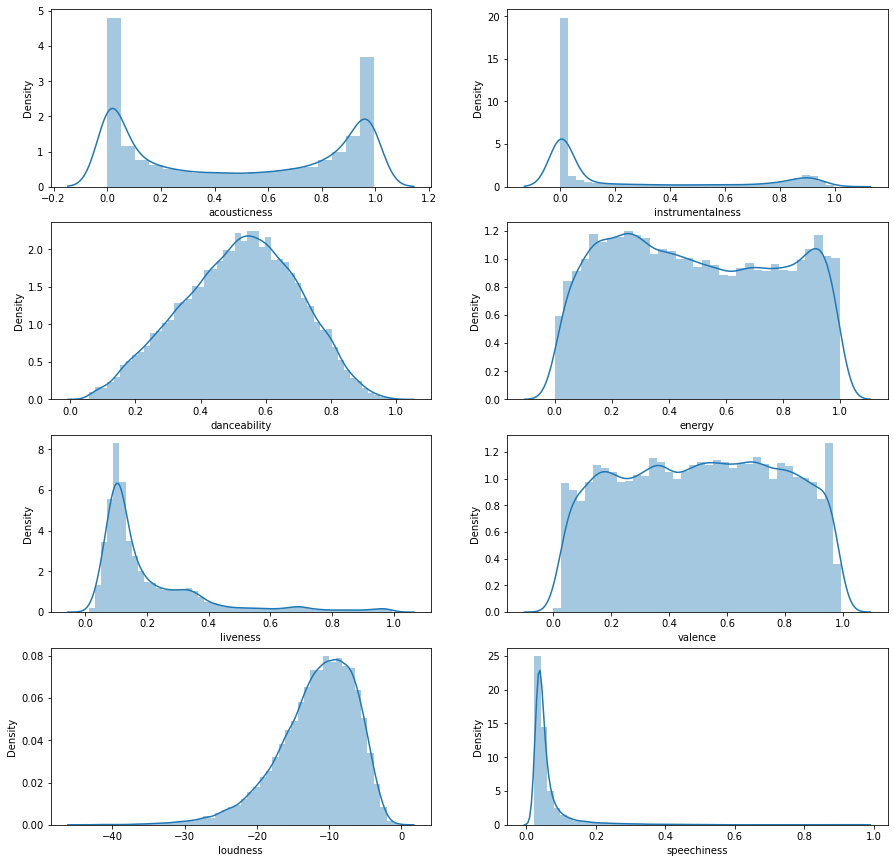

In [94]:
f, axes = plt.subplots(4, 2, figsize=(15, 15))

sns.distplot(df_use['acousticness'], ax=axes[0, 0])

sns.distplot(df_use['instrumentalness'], ax=axes[0, 1])

sns.distplot(df_use['danceability'], ax=axes[1, 0])

sns.distplot(df_use['energy'], ax=axes[1, 1])

sns.distplot(df_use['liveness'], ax=axes[2, 0])

sns.distplot(df_use['valence'], ax=axes[2, 1])

sns.distplot(df_use['loudness'], ax=axes[3, 0])

sns.distplot(df_use['speechiness'], ax=axes[3, 1])


plt.show()

### 3) 데이터 정규화
#### loudness의 경우 이상치 데이터가 존재하고, 다른 데이터들과 범위의 차이가 있어 이상치 제거 후 MinMaxScaler를 사용하여 정규화

In [95]:
def get_outlier(df=None, column=None, weight=1.5):
  quantile_25 = np.percentile(df[column].values, 25)
  quantile_75 = np.percentile(df[column].values, 75)

  IQR = quantile_75 - quantile_25
  IQR_weight = IQR*weight
  
  lowest = quantile_25 - IQR_weight
  highest = quantile_75 + IQR_weight
  
  outlier_idx = df[column][ (df[column] < lowest) | (df[column] > highest) ].index
  return outlier_idx

In [96]:
# 함수 사용해서 이상치 값 삭제
outlier_idx = get_outlier(df=df_use, column='loudness', weight=1.5)
df_use.drop(outlier_idx, axis=0, inplace=True)

<AxesSubplot:xlabel='loudness', ylabel='Density'>

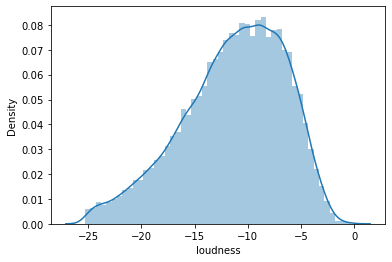

In [97]:
sns.distplot(df_use['loudness'])

In [98]:
MM = MinMaxScaler()
X = df_use['loudness'].values.reshape(-1,1)
X_new = MM.fit_transform(X)
X_new

array([[0.47911332],
       [0.33658771],
       [0.36371639],
       ...,
       [0.76776569],
       [0.69886364],
       [0.81482074]])

<AxesSubplot:ylabel='Density'>

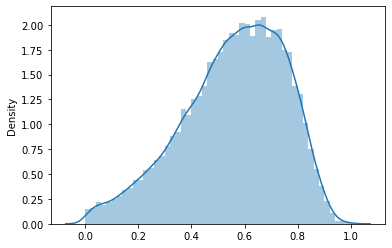

In [99]:
sns.distplot(X_new)

In [100]:
df_use['loudness'] = X_new
df_use.head()

,id,name,artists,acousticness,instrumentalness,danceability,energy,liveness,valence,loudness,speechiness,lang
1,35iwgR4jXetI318WEWsa1Q,Carve,['Uli'],0.674,0.744000,0.645,0.445,0.151,0.127,0.479113,0.4510,en
5,08y9GfoqCWfOGsKdwojr5e,Lady of the Evening,['Dick Haymes'],0.989,0.130000,0.402,0.158,0.311,0.196,0.336588,0.0390,en
9,0IgI1UCz84pYeVetnl1lGP,Old Fashioned Girl,['Greg Fieler'],0.620,0.006450,0.488,0.475,0.107,0.544,0.363716,0.0399,en
32,1HXdv1z9RlvrcUernyf0MY,The Dear Little Shamrock,['Dick Haymes'],0.991,0.000133,0.347,0.197,0.196,0.246,0.386524,0.0504,en
37,1O9iZyzufN1fUdVO97mmm5,How High the Moon,"['Dick Haymes', 'Harry James', 'His Orchestra']",0.989,0.277000,0.328,0.307,0.210,0.259,0.549736,0.0484,en


### 4) 추천 후 출력결과를 위해 artists 컬럼 특수기호 제거

In [101]:
artists = []
for ids in df_use['artists']:
    ids = ids.replace("[","")
    ids = ids.replace("'","",12)
    ids = ids.replace("]","")
    
    artists.append(ids)
df_use['artists'] = artists
df_use.head()

,id,name,artists,acousticness,instrumentalness,danceability,energy,liveness,valence,loudness,speechiness,lang
1,35iwgR4jXetI318WEWsa1Q,Carve,Uli,0.674,0.744000,0.645,0.445,0.151,0.127,0.479113,0.4510,en
5,08y9GfoqCWfOGsKdwojr5e,Lady of the Evening,Dick Haymes,0.989,0.130000,0.402,0.158,0.311,0.196,0.336588,0.0390,en
9,0IgI1UCz84pYeVetnl1lGP,Old Fashioned Girl,Greg Fieler,0.620,0.006450,0.488,0.475,0.107,0.544,0.363716,0.0399,en
32,1HXdv1z9RlvrcUernyf0MY,The Dear Little Shamrock,Dick Haymes,0.991,0.000133,0.347,0.197,0.196,0.246,0.386524,0.0504,en
37,1O9iZyzufN1fUdVO97mmm5,How High the Moon,"Dick Haymes, Harry James, His Orchestra",0.989,0.277000,0.328,0.307,0.210,0.259,0.549736,0.0484,en


### 5) 추천을 위한 popularity, release_date 변수 추가

In [102]:
etc = df[['id','release_date','popularity']]
print(df_use.shape)
df_use = pd.merge(df_use, etc, on="id", how="left")
print(df_use.shape)

(33381, 12)
(33381, 14)


In [103]:
df_use.head()

,id,name,artists,acousticness,instrumentalness,danceability,energy,liveness,valence,loudness,speechiness,lang,release_date,popularity
0,35iwgR4jXetI318WEWsa1Q,Carve,Uli,0.674,0.744000,0.645,0.445,0.151,0.127,0.479113,0.4510,en,1922-02-22,6
1,08y9GfoqCWfOGsKdwojr5e,Lady of the Evening,Dick Haymes,0.989,0.130000,0.402,0.158,0.311,0.196,0.336588,0.0390,en,1922,0
2,0IgI1UCz84pYeVetnl1lGP,Old Fashioned Girl,Greg Fieler,0.620,0.006450,0.488,0.475,0.107,0.544,0.363716,0.0399,en,1922,0
3,1HXdv1z9RlvrcUernyf0MY,The Dear Little Shamrock,Dick Haymes,0.991,0.000133,0.347,0.197,0.196,0.246,0.386524,0.0504,en,1922,0
4,1O9iZyzufN1fUdVO97mmm5,How High the Moon,"Dick Haymes, Harry James, His Orchestra",0.989,0.277000,0.328,0.307,0.210,0.259,0.549736,0.0484,en,1922,0


## 3. 데이터 저장

In [104]:
#df_use.to_csv("data_real_final.csv", encoding="utf-8", index=False)